# Hedging a theoretical market exposed load

* asdsa
* asdasdf
* dfg

## Import Packages

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import pytz
import calendar

import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import hvplot.pandas

from statsmodels.tsa.seasonal import seasonal_decompose

import nemdata

import sqlite3

## Select Region and Date Range

In [2]:
drop_region = widgets.Dropdown(options=['NSW1', 'TAS1', 'SA1', 'QLD1', 'VIC1'],description='State:',disabled=False,index=4)

button = widgets.Button(description="Select")

def on_button_clicked(b):
    global region
    region = drop_region.value
    print(f"The selected region is: {region}")

button.on_click(on_button_clicked)

display(drop_region)
display(button)

Dropdown(description='State:', index=4, options=('NSW1', 'TAS1', 'SA1', 'QLD1', 'VIC1'), value='VIC1')

Button(description='Select', style=ButtonStyle())

## Import Data

In [2]:
todays_date = dt.datetime.now(tz=pytz.timezone('Australia/Brisbane')).date()
days_in_month = calendar.monthrange(todays_date.year,todays_date.month)[1]
todays_date = (todays_date-dt.timedelta(days=days_in_month))
year_month = todays_date.strftime("%Y-%m")
year_month

'2024-05'

In [4]:
# Uncomment below if first time, after the first download the data is stored in a database

#data_price = nemdata.download(start="2020-01", end=year_month, table="trading-price")
#data_demand = nemdata.download(start="2020-01", end=year_month, table="demand")
data_price = nemdata.load()['trading-price']
data_demand = nemdata.load()['demand']

nemdata load:

found: ['demand', 'trading-price']

load: ['demand', 'trading-price']

nemdata load:

found: ['demand', 'trading-price']

load: ['demand', 'trading-price']

In [6]:
price_all_region = data_price.loc[:,['interval-end','REGIONID',
       'RRP',
       'RAISE6SECRRP', 'RAISE60SECRRP','RAISE5MINRRP', 'RAISEREGRRP',
       'LOWER6SECRRP', 'LOWER60SECRRP','LOWER5MINRRP', 'LOWERREGRRP']]
price_all_region.set_index('interval-end',inplace=True)
price_all_region.sort_index(ascending=True,inplace=True)
price_all_region.index = price_all_region.index.tz_localize(None)
price_all_region.reset_index(inplace=True)
price_all_region.rename(columns={'interval-end':'SETTLEMENTDATE'},inplace=True)

demand_all_region = data_demand.loc[:,['SETTLEMENTDATE','REGIONID','TOTALDEMAND']]
demand_all_region.set_index('SETTLEMENTDATE',inplace=True)
demand_all_region.sort_index(ascending=True,inplace=True)
demand_all_region.index = demand_all_region.index.tz_localize(None)
demand_all_region.reset_index(inplace=True)

price_demand_all_regions = price_all_region.merge(demand_all_region,how='left')

In [68]:
# region_prices = {}

# for region in price_demand_all_regions.REGIONID.unique():
#     region_prices[region] = price_demand_all_regions.loc[price_demand_all_regions.REGIONID==region,:]

In [7]:
#Create a connection to the data base and initiate a cursor
conn = sqlite3.connect("NEM_historical.db")
cur = conn.cursor()

#Create the table if it dosen't exist
cur.execute("""CREATE TABLE IF NOT EXISTS nem_data(
                    SETTLEMENTDATE TEXT,
                    REGIONID TEXT,
                    RRP REAL,
                    RAISE6SECRRP REAL, 
                    RAISE60SECRRP REAL,
                    RAISE5MINRRP REAL, 
                    RAISEREGRRP REAL,
                    LOWER6SECRRP REAL, 
                    LOWER60SECRRP REAL,
                    LOWER5MINRRP REAL, 
                    LOWERREGRRP REAL,
                    TOTALDEMAND REAL
                    )""")
conn.commit()

#Add the data_region to the dataframe by appending it
price_demand_all_regions.to_sql('nem_data', conn, if_exists='append', index=False)
#Check the data base table and if duplicates exists remove them from the data base
conn.execute("""DELETE FROM nem_data
WHERE rowid NOT IN (
    SELECT MIN(rowid)
    FROM nem_data
    GROUP BY SETTLEMENTDATE, REGIONID, RRP, RAISE6SECRRP, RAISE60SECRRP, RAISE5MINRRP, RAISEREGRRP, LOWER6SECRRP, LOWER60SECRRP, LOWER5MINRRP, LOWERREGRRP, TOTALDEMAND)
    """)
conn.commit()

In [8]:
#Create a connection to the data base and initiate a cursor
conn = sqlite3.connect("NEM_historical.db")
cur = conn.cursor()

#Select all the rows where the product is cap
NEM_ALL_DATA = cur.execute("""SELECT * 
                        FROM nem_data
                        WHERE REGIONID = 'SA1'
                        """)
conn.commit()
NEM_ALL_DATA = pd.DataFrame(NEM_ALL_DATA.fetchall(),columns=['SETTLEMENTDATE','REGIONID','RRP', 'RAISE6SECRRP', 'RAISE60SECRRP', 'RAISE5MINRRP', 'RAISEREGRRP', 'LOWER6SECRRP', 'LOWER60SECRRP', 'LOWER5MINRRP', 'LOWERREGRRP','TOTALDEMAND'])

In [9]:
NEM_ALL_DATA.SETTLEMENTDATE = pd.to_datetime(NEM_ALL_DATA.SETTLEMENTDATE)
NEM_ALL_DATA.set_index('SETTLEMENTDATE',inplace=True)

In [10]:
NEM_ALL_DATA.head()

,REGIONID,RRP,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,LOWER5MINRRP,LOWERREGRRP,TOTALDEMAND
SETTLEMENTDATE,,,,,,,,,,,
2020-01-01 00:05:00,SA1,68.33,1.75,2.47,0.73,19.24,0.05,0.38,0.44,15.68,1466.53
2020-01-01 00:10:00,SA1,68.33,1.75,2.47,0.73,19.24,0.05,0.38,0.44,15.68,1422.33
2020-01-01 00:15:00,SA1,68.33,1.75,2.47,0.73,19.24,0.05,0.38,0.44,15.68,1425.70
2020-01-01 00:20:00,SA1,68.33,1.75,2.47,0.73,19.24,0.05,0.38,0.44,15.68,1423.95
2020-01-01 00:25:00,SA1,68.33,1.75,2.47,0.73,19.24,0.05,0.38,0.44,15.68,1389.36


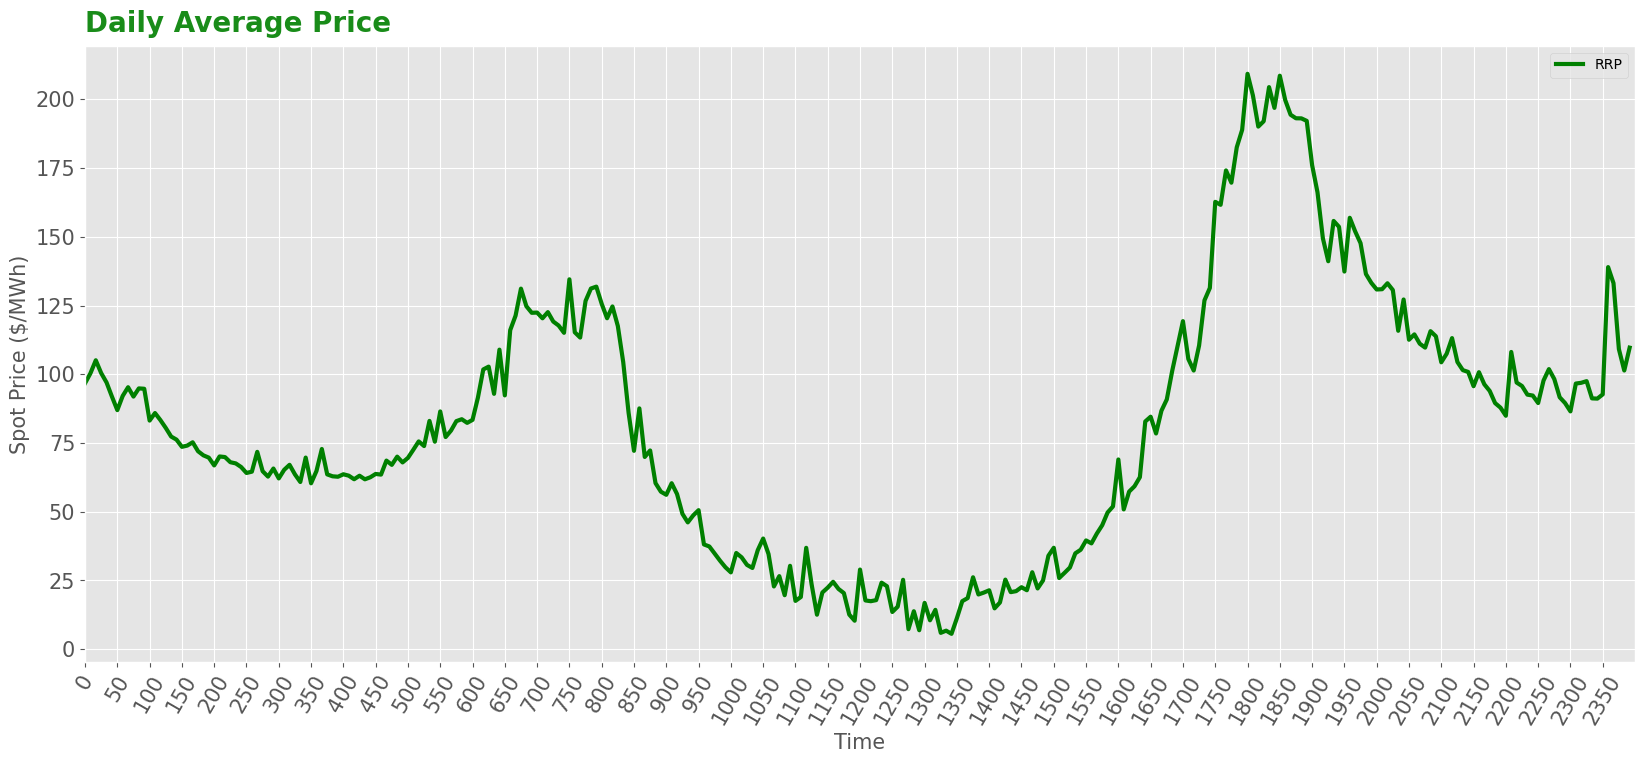

In [11]:
daily_average = NEM_ALL_DATA.groupby(NEM_ALL_DATA.index.time)[['RRP']].mean()

fig, ax = plt.subplots(figsize=(20,8))
daily_average.plot(ax=ax,color='green',linewidth=3)
plt.title('Daily Average Price', alpha=0.9, weight="bold", fontsize=20, loc="left", pad=10,color="green")
plt.ylabel("Spot Price ($/MWh)",fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Time",fontsize=15)
plt.xticks(fontsize=15)
plt.xticks(ticks=range(0,86400,1800),labels=range(0,2400,50),rotation=60)
plt.xlim((0,86400))
plt.show()

C:\Users\Lachlan\AppData\Local\Temp\ipykernel_14444\1241404304.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust spacing between subplots


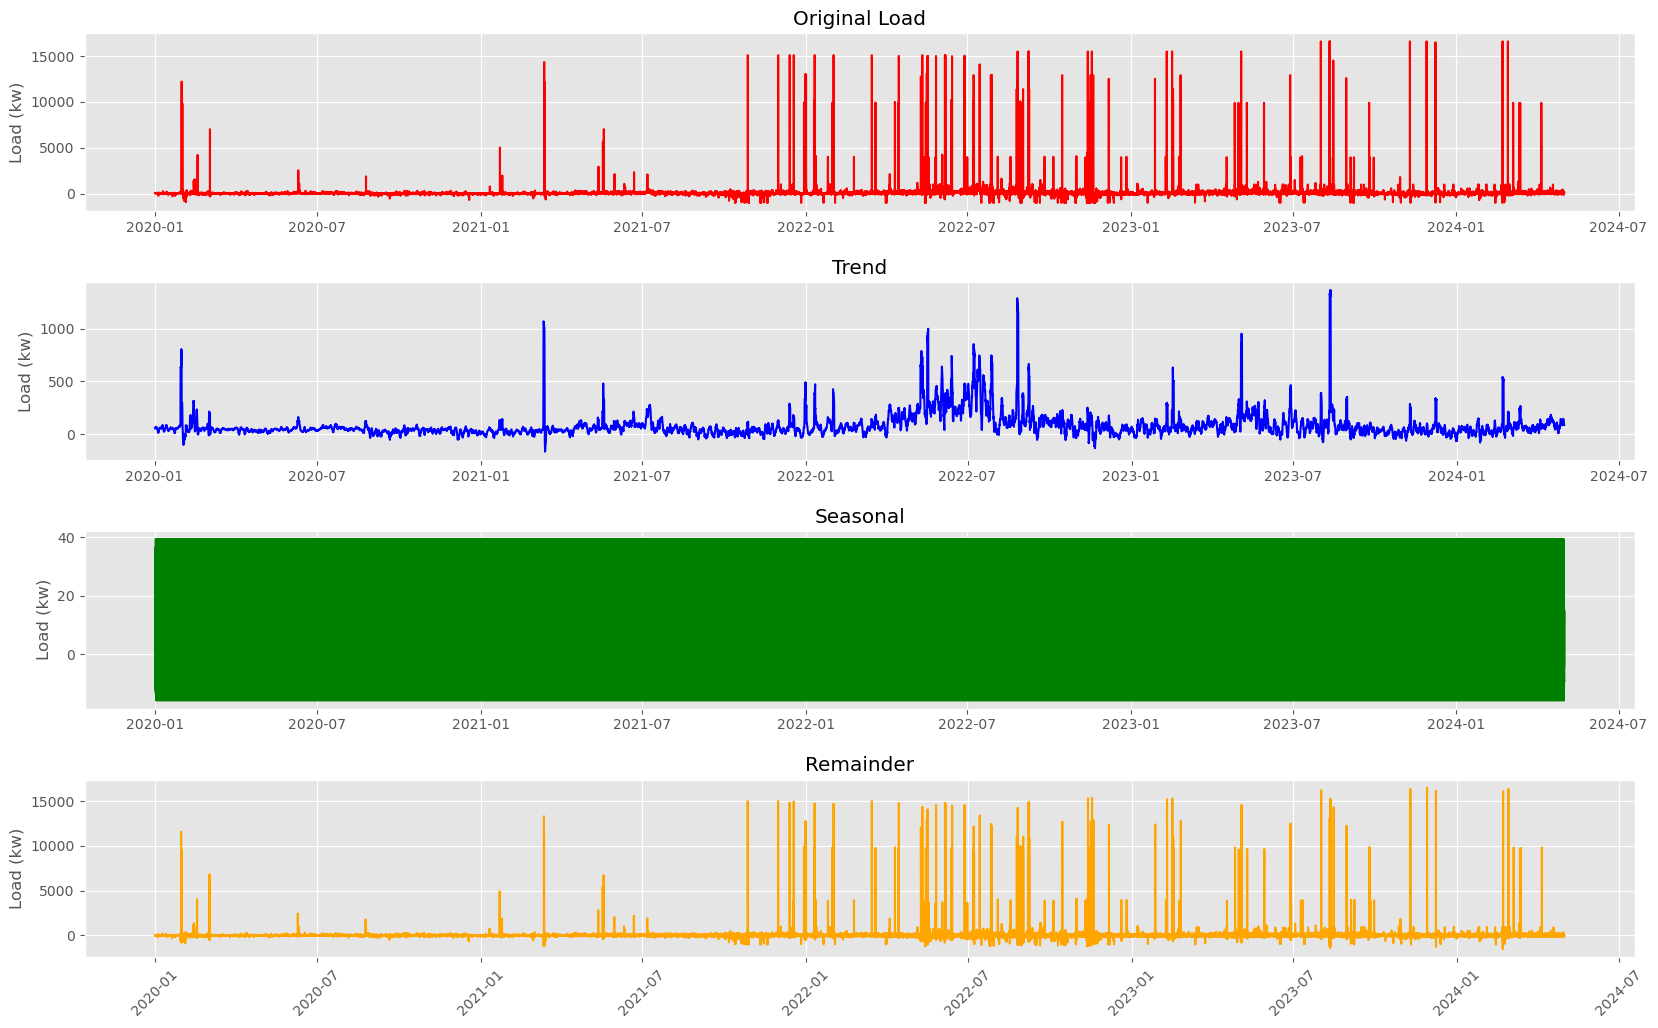

In [14]:
data_region_decom = NEM_ALL_DATA[['RRP']]
# Decompose the data
decomposition = seasonal_decompose(data_region_decom,period=365)

# Extract componets
trend = decomposition.trend
seasonal = decomposition.seasonal
remainder = decomposition.resid
original = NEM_ALL_DATA['RRP']

# Create a figure with 4 subplots (original on top, others stacked below)
fig, axes = plt.subplots(4, 1, figsize=(20, 12), gridspec_kw={'hspace': 0.4})  # Adjust figsize as needed

# Plot original on top subplot
axes[0].plot(original, color='red', label='Original Load')
axes[0].set(ylabel='Load (kw)', title='Original Load')

# Plot remaining components on stacked subplots
axes[1].plot(trend, color='blue', label='Trend')
axes[1].set(ylabel='Load (kw)', title='Trend')
axes[2].plot(seasonal, color='green', label='Seasonal')
axes[2].set(ylabel='Load (kw)', title='Seasonal')
axes[3].plot(remainder, color='orange', label='Remainder')
axes[3].set(ylabel='Load (kw)', title='Remainder')

# Rotate x-axis labels for bottom subplot
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

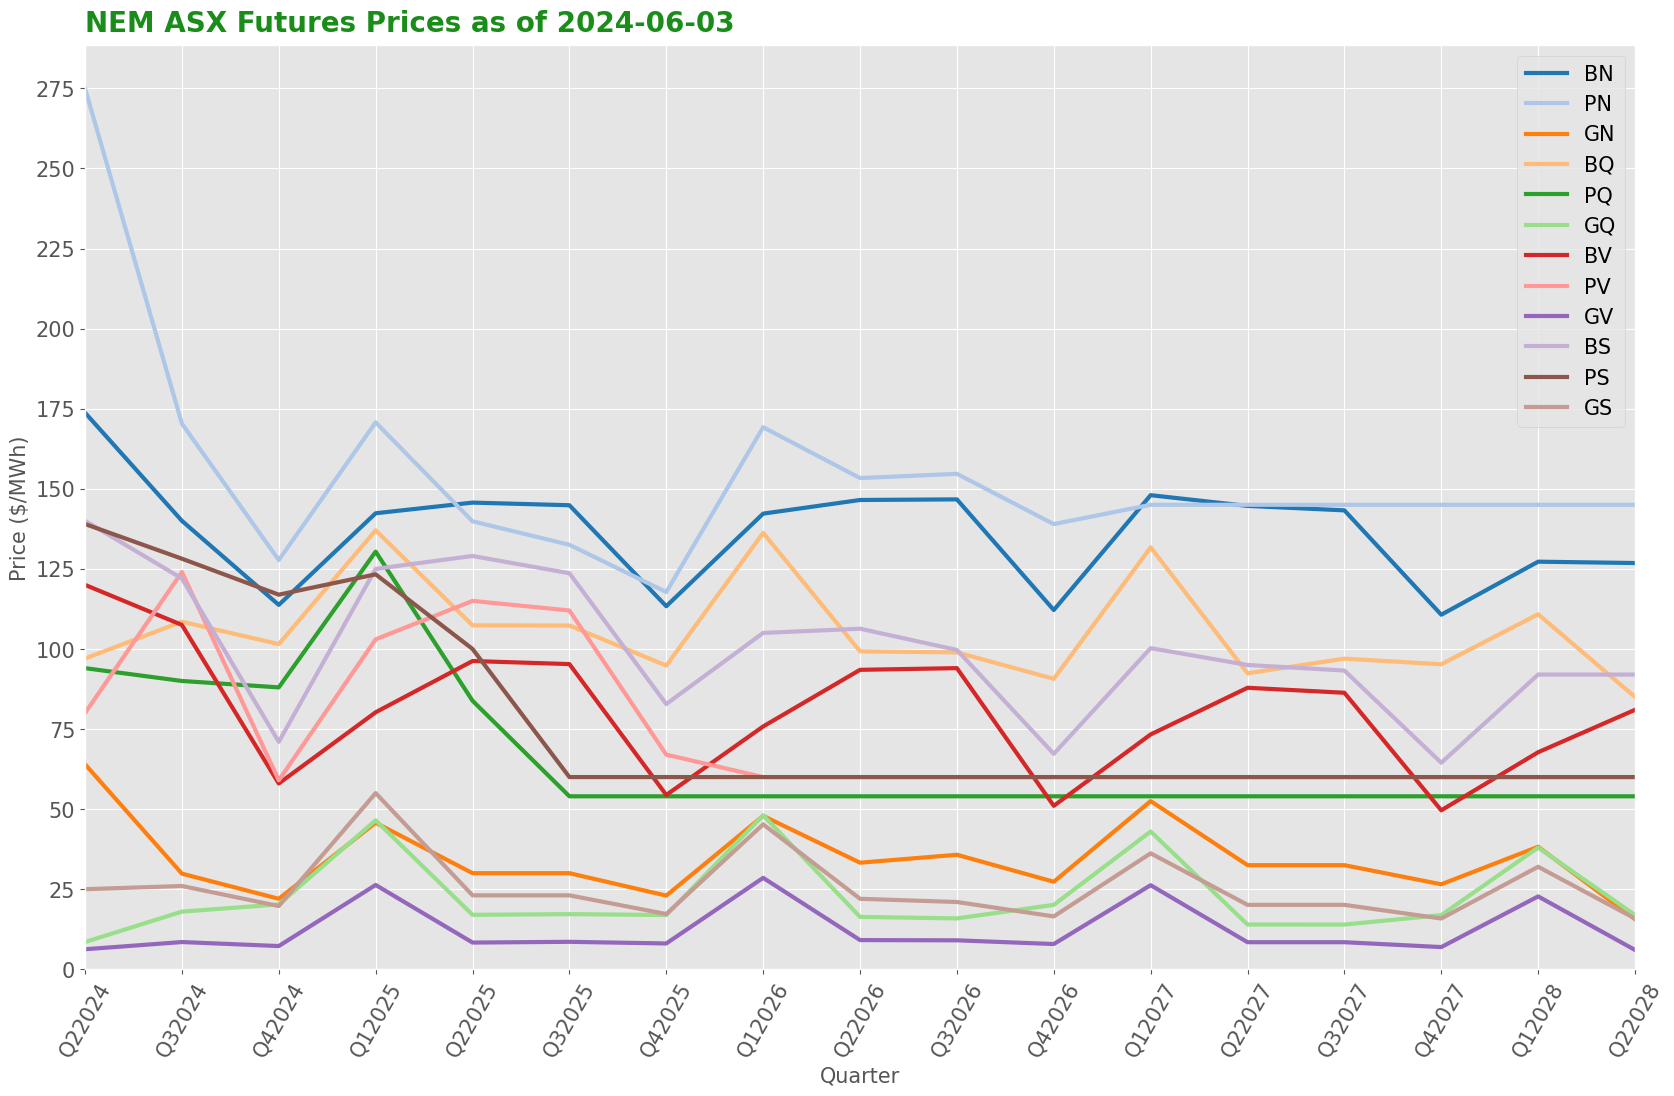

,BN,PN,GN,BQ,PQ,GQ,BV,PV,GV,BS,PS,GS
Type,,,,,,,,,,,,
Q22024,173.75,275.0,64.0,97.0,94.0,8.5,120.0,80.0,6.25,140.0,139.0,25.0
Q32024,140.0,170.34,29.85,108.5,90.0,18.0,107.5,124.0,8.5,122.0,128.17,26.0
Q42024,113.75,127.75,22.0,101.5,88.0,20.25,58.0,59.0,7.25,71.0,116.94,19.74
Q12025,142.36,170.73,45.75,137.03,130.38,46.5,80.23,103.0,26.32,125.0,123.29,55.0
Q22025,145.68,139.84,30.0,107.37,83.83,17.0,96.23,115.0,8.34,129.02,100.0,23.08
Q32025,144.86,132.51,30.0,107.32,54.0,17.21,95.27,112.0,8.57,123.63,60.0,23.08
Q42025,113.34,117.76,23.0,94.79,54.0,16.94,54.41,67.0,8.06,82.79,60.0,17.25
Q12026,142.24,169.21,47.89,136.23,54.0,48.08,75.8,60.0,28.54,105.0,60.0,45.25
Q22026,146.5,153.34,33.27,99.25,54.0,16.35,93.48,60.0,9.11,106.31,60.0,22.0


In [15]:
url = 'https://www.asxenergy.com.au/futures_au/dataset/'
product_codes = ['BN','PN','GN','BQ','PQ','GQ','BV','PV','GV','BS','PS','GS']
product_values = {}
date_of_extraction = dt.datetime.now(tz=pytz.timezone('Australia/Brisbane')).date()

def webscrape_asx_data(url):
    """
    Input: url of web page to have table extracted
    Output: a data frame of the table that was web scraped
    """
    read_html_pandas_data = pd.read_html(url)
    df = read_html_pandas_data[0].rename(columns={'Date':'Type'})
    df = df.set_index('Type')
    return df

# Iterate through the urls and pass them to the webscrape function and store the result in the return_values dic
for code in product_codes:
    product_values[code] = webscrape_asx_data(url+code)
    
# Create a data frame with just the price of the base, peaks and caps
asx_futures = pd.DataFrame(index=product_values['BN'].index,columns=product_codes)
# Add all the values to the dataframe
for code in product_codes:
    asx_futures.loc[product_values['BN'].index,code] = product_values[code].loc[product_values['BN'].index,'PrevClose']

fig, ax = plt.subplots(figsize=(20,12))

# Define the colormap
cmap = plt.get_cmap("tab20")

# Plot each line with a different color
for idx, column in enumerate(asx_futures.columns):
    asx_futures[column].plot(ax=ax, linewidth=3, color=cmap(idx))
    
plt.title(f"NEM ASX Futures Prices as of {date_of_extraction}",alpha=0.9, weight="bold", fontsize=20, loc="left", pad=10,color="green")
plt.ylabel("Price ($/MWh)",fontsize=15)
plt.yticks(ticks=range(0,300,25),labels=range(0,300,25),fontsize=15)
plt.ylim(0)
plt.xlabel("Quarter",fontsize=15)
plt.xticks(fontsize=15)
plt.xticks(ticks=range(0,17),labels=asx_futures.index,rotation=60)
plt.xlim((0, len(asx_futures.index) - 1))
plt.legend(fontsize=15)
plt.show()    
     
asx_futures

In [16]:
### Save current day results to local Database

#Create a copy of the VIC_base_and_cap dataframe
asx_data_for_db = asx_futures.copy()
#Reset the index
asx_data_for_db = asx_data_for_db.reset_index()
#Melt the df so that each row has individual information
asx_data_for_db = asx_data_for_db.melt(id_vars=['Type'],var_name='Product',value_name='Price')
#Add a column with todays data
asx_data_for_db['Date'] = date_of_extraction

#The data frame asx_data_for_db is to be loaded into the data base called ASX_historical into the table asx_data

#Create a connection to the data base and initiate a cursor
conn = sqlite3.connect("ASX_historical.db")
cur = conn.cursor()

#Create the table if it dosen't exist
cur.execute("""CREATE TABLE IF NOT EXISTS asx_data(
                    Type TEXT,
                    Product INT, 
                    Price Real, 
                    Date TEXT
                    )""")
conn.commit()

#Add the asx_data_for_db to the dataframe by appending it
asx_data_for_db.to_sql('asx_data', conn, if_exists='append', index=False)
#Check the data base table and if duplicates exists remove them from the data base
conn.execute("""DELETE FROM asx_data
    WHERE rowid NOT IN (
    SELECT MIN(rowid)
    FROM asx_data
    GROUP BY Type, Product, Date)
    """)
conn.commit()

historical_asx_data = {}
for code in product_codes:
    #Select all the rows where the product equal to the current product code in the iteration
    results = cur.execute("""SELECT * 
                            FROM asx_data
                            WHERE Product = :code
                            """,{"code":code})
    conn.commit()
    historical_asx_data[code] = pd.DataFrame(results.fetchall(),columns=['Quarter','Product','Price','Date'])

In [32]:
test = historical_asx_data['BS'].loc[historical_asx_data['BS'].Quarter=='Q22024',:]
test.Date = pd.to_datetime(test.Date)
test.set_index('Date',inplace=True)

C:\Users\Lachlan\AppData\Local\Temp\ipykernel_14444\448280549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.Date = pd.to_datetime(test.Date)


In [33]:
test.index

DatetimeIndex(['2024-06-01', '2024-06-02', '2024-06-03'], dtype='datetime64[ns]', name='Date', freq=None)

<Axes: xlabel='Date'>

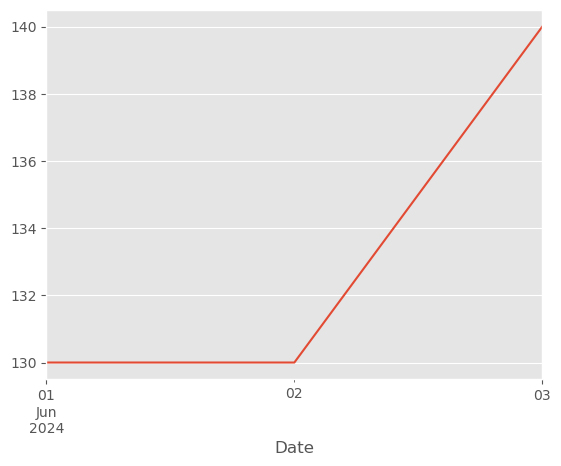

In [36]:
test.Price.plot()